In [74]:
!pip install torch

In [75]:
!pip install torchvision

In [76]:
import torch
print(torch.__version__)
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

1.5.1+cu101


In [77]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io 

In [78]:
#Loading cvs file with dataset
from google.colab import files
data_to_load = files.upload()

Saving vgsales.csv to vgsales (3).csv


In [79]:
#Converting csv to dataset
raw_dataset = pd.read_csv(io.BytesIO(data_to_load['vgsales.csv']),
                      na_values = "?", comment='\t',
                      sep=",")

dataset = raw_dataset.copy()
dataset.tail()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.0,0.0,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.0,0.0,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.0,0.0,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.0,0.0,0.01
16597,16600,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.0,0.0,0.01


In [80]:
dataset.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [81]:
#Preparing data set
dataset = dataset.dropna()
dataset = dataset.drop(['Rank'], axis=1)
dataset = dataset.drop(['Name'], axis=1)
dataset = dataset.drop(['EU_Sales'], axis =1 )
dataset = dataset.drop(['JP_Sales'], axis=1)
dataset = dataset.drop(['Other_Sales'], axis=1)

#Drop all rows with 0 sales
dataset= dataset.drop(dataset[dataset['Global_Sales'] == 0.00].index)

In [82]:
#Convert categorical values to numbers
dataset['Platform'] = pd.factorize(dataset['Platform'] )[0] 
dataset['Genre'] = pd.factorize(dataset['Genre'] )[0]
dataset['Publisher'] = pd.factorize(dataset['Publisher'] )[0]
dataset['Year'] = pd.factorize(dataset['Year'] )[0]


In [83]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [84]:
train_stats = train_dataset.describe()
train_stats.pop("Global_Sales")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Platform,13033.0,8.621192,5.896936,0.0,4.0,6.00,13.00,30.00
Year,13033.0,12.683342,8.756012,0.0,4.0,11.00,19.00,38.00
Genre,13033.0,5.275838,3.423228,0.0,2.0,6.00,8.00,11.00
Publisher,13033.0,60.966700,101.047275,0.0,7.0,19.00,57.00,575.00
NA_Sales,13033.0,0.262122,0.779143,0.0,0.0,0.08,0.24,29.08


In [85]:
#Separate dataset to training and test
train_labels = train_dataset.pop('Global_Sales')
test_labels = test_dataset.pop('Global_Sales')

In [86]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_labels = norm(train_labels)
normed_test_labels = norm(test_labels)

In [87]:
#loading data into pytorch tensors 
train_tensor = torch.Tensor(normed_train_data.values)
test_tensor = torch.Tensor(normed_test_data.values)
train_labels_tensor = torch.Tensor(train_labels.values)
test_labels_tensor = torch.Tensor(test_labels.values)

In [88]:
#Model building 
model = torch.nn.Sequential(
    torch.nn.Linear(train_tensor.size()[1], 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
    
)

In [89]:
#define loss function with learning rate
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 2000

In [90]:
import time

start = time.time()

model.train()
train_loss = []
for epoch in range(epochs):
  optimizer.zero_grad() 

  prediction = model(train_tensor)
  loss = loss_fn(prediction.squeeze(), train_labels_tensor)
  train_loss.append(loss.item())
  #print(loss)

  loss.backward()
  optimizer.step()

  #print 
  train_pred_nump = prediction.detach().numpy()
  train_label_nump = train_labels_tensor.numpy()
  print('epoch {}, loss {}, predicion {}, label {}'.format(epoch, loss.item(), train_pred_nump[epoch], train_label_nump[epoch] ))
end = time.time()
print(end - start)

epoch 0, loss 2.31101393699646, predicion [0.0448471], label 0.1899999976158142
epoch 1, loss 2.298290967941284, predicion [0.19932434], label 0.1899999976158142
epoch 2, loss 2.2857508659362793, predicion [0.06230923], label 0.019999999552965164
epoch 3, loss 2.273390054702759, predicion [0.0058493], label 0.10000000149011612
epoch 4, loss 2.261204481124878, predicion [0.42591053], label 0.029999999329447746
epoch 5, loss 2.249189853668213, predicion [0.14047575], label 0.23000000417232513
epoch 6, loss 2.2373368740081787, predicion [0.02451424], label 0.14000000059604645
epoch 7, loss 2.225645065307617, predicion [0.14484233], label 0.2199999988079071
epoch 8, loss 2.2141096591949463, predicion [0.13366508], label 0.029999999329447746
epoch 9, loss 2.2027275562286377, predicion [0.05958663], label 2.559999942779541
epoch 10, loss 2.1914944648742676, predicion [-0.00130617], label 0.07000000029802322
epoch 11, loss 2.180408477783203, predicion [0.05219183], label 0.029999999329447746


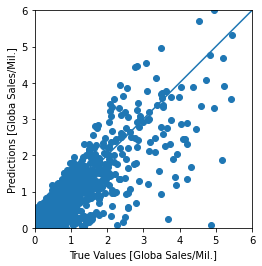

In [95]:
#testing predictions 
model.eval()
with torch.no_grad():
  test_predictions = model(test_tensor)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Globa Sales/Mil.]')
plt.ylabel('Predictions [Globa Sales/Mil.]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

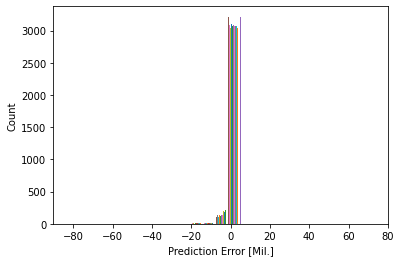

In [96]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Mil.]")
_ = plt.ylabel("Count")